In [101]:
from pinecone import Pinecone, ServerlessSpec

from transformers import CLIPProcessor, CLIPModel
import os
import torch
import base64
import pandas as pd
import io

from dotenv import load_dotenv




load_dotenv()


import sys 

from IPython import display 
from PIL import Image

sys.path.append("..")
sys.path.append("../utlities")
from utlities.directories import  IMAGES_FOLDER



In [2]:

pc = Pinecone(api_key=os.environ.get('PINECONE_API_KEY'))


CLIP_INDEX_NAME = "clip-email-index"

if not pc.has_index(CLIP_INDEX_NAME):
  pc.create_index(
      name=CLIP_INDEX_NAME,
      dimension=512,
      metric="cosine",
      spec=ServerlessSpec(
          cloud='aws',
          region='us-east-1'
      )
  )

index = pc.Index(CLIP_INDEX_NAME)


In [46]:


# TODO - clip models? 
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)
model.to("cpu")




def create_image_embeddings(image):
    if image is None:
        return None
        
    vals = processor(
          text=[""],
          images=image,
          return_tensors='pt')['pixel_values'].to("cpu")
    image_embedding = model.get_image_features(vals)
    return image_embedding[0]         


In [ ]:
 
def apply_vectorization(data):

  data["image_embeddings"] = create_image_embeddings(data["image"])
  return data



In [27]:
## TODO - handle avif images somehow...

# /Users/charlienatoli/coding_projects/email_content_search/.venv/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
#   warnings.warn(


images = os.listdir(IMAGES_FOLDER)
images = [im for im in images if not im.startswith(".")]

def open_image(image_name):
    try: 
        return Image.open(os.path.join(IMAGES_FOLDER, image_name))
    except: 
        return None

images_df = pd.DataFrame({
    "image_filenames": images
})

images_df['image'] = images_df['image_filenames'].apply(open_image)

In [47]:
images_df['image_embeddings'] = images_df['image'].apply(create_image_embeddings)
 

/Users/charlienatoli/coding_projects/email_content_search/.venv/lib/python3.11/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [53]:
# why do we need a caption?

vectors = []


for i in range(0, images_df.shape[0]):
    d = images_df.loc[i]
    if d['image'] is None:
        continue
    vectors.append({
      "id": d["image_filenames"],
      "values": d["image_embeddings"],
      "metadata": {"caption": ""}
  })



index.upsert(
    vectors=vectors,
    namespace="ns1"
)

{'upserted_count': 292}

In [57]:

def create_text_embeddings(text):
  text_embedding = processor(text=text,
      padding=True,
      images=None,
      return_tensors='pt').to("cpu")
    
  text_emb = model.get_text_features(**text_embedding)
  return text_emb[0]


In [112]:
def show_emails_html_from_query(
    results,
    images_df: pd.DataFrame
) -> str:

    def inner_photo_div(image_file):
                  
        
        # Convert the image to bytes first
        buffer = io.BytesIO()
        image_file.save(buffer, format="PNG")
        image_bytes = buffer.getvalue()
        
        # Now encode the bytes
        encoded_string = base64.b64encode(image_bytes).decode('utf-8')
                
        return f"""   
            <div style="width: 20%;">  
                    <div style="height: 600px; overflow: hidden;">
                        <img src="data:image/jpeg;base64,{encoded_string}" style="width: 100%;">

                    </div>        
                </div> 
            """

    image_files = [
        images_df[images_df['image_filenames'] == m['id']]['image'].iloc[0]
        for m in results['matches']
    ]
    
    html_content = f"""<div class="row" style="display: flex; justify-content: space-between; align-items: flex-start;">   
            <div style="display: flex; flex-direction: column; align-items: center; width: 95%;">      
                <h2>Relevant Emails</h2>
                <div class="row" style="display: flex; flex-wrap: wrap; justify-content: space-between; width: 100%; align-items: flex-start;"> 
            {''.join(inner_photo_div(image_file) for image_file in image_files)}
            </div>
        </div>
    </div> 
    """

    return html_content
 


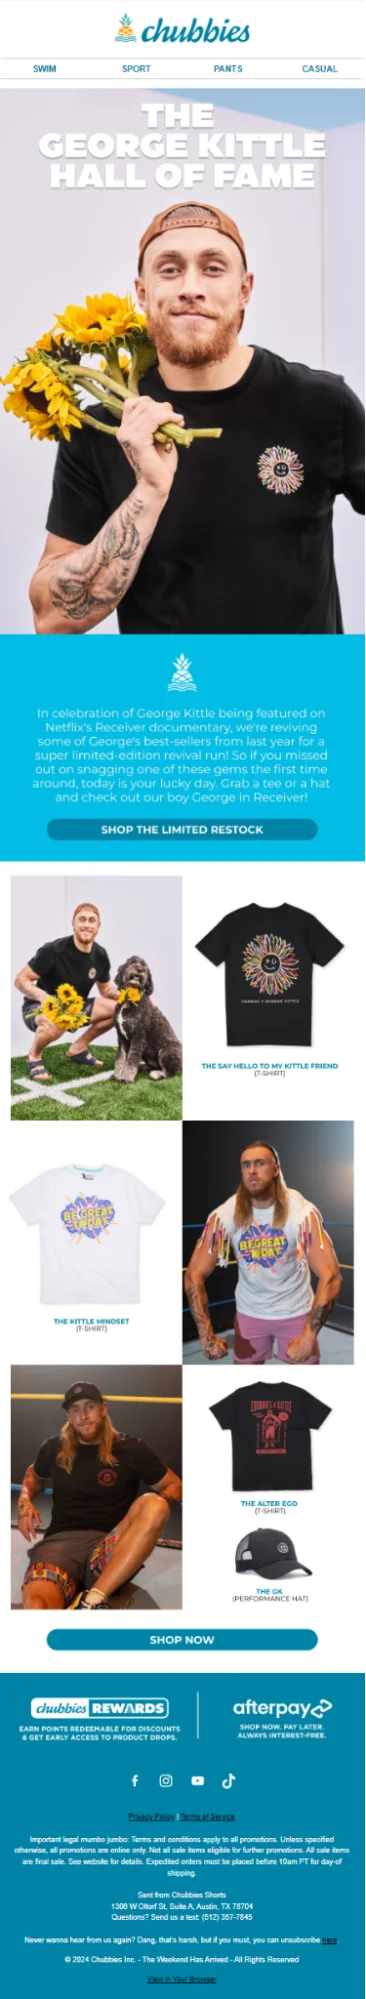
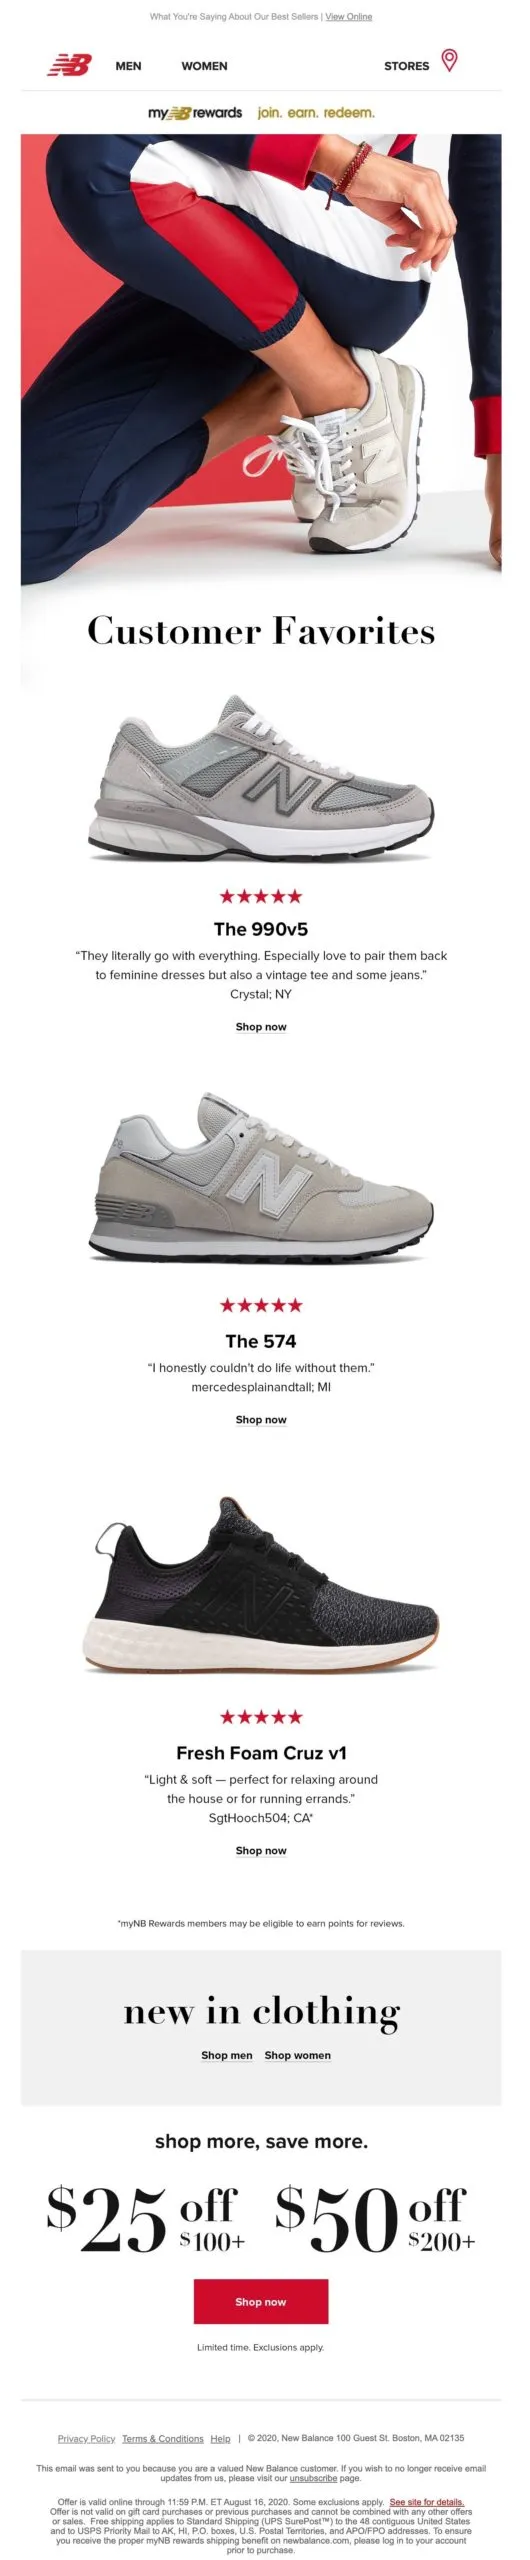
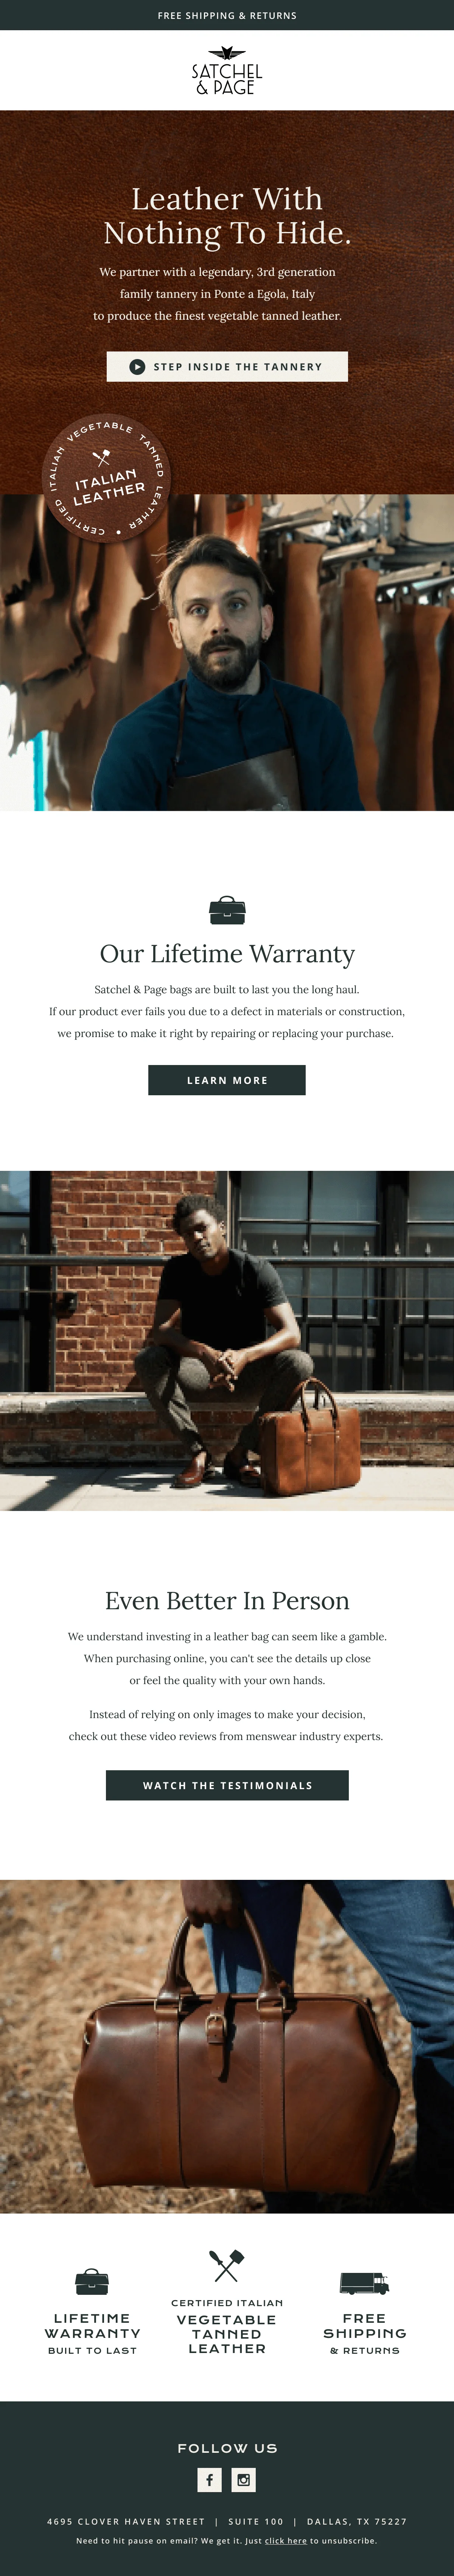
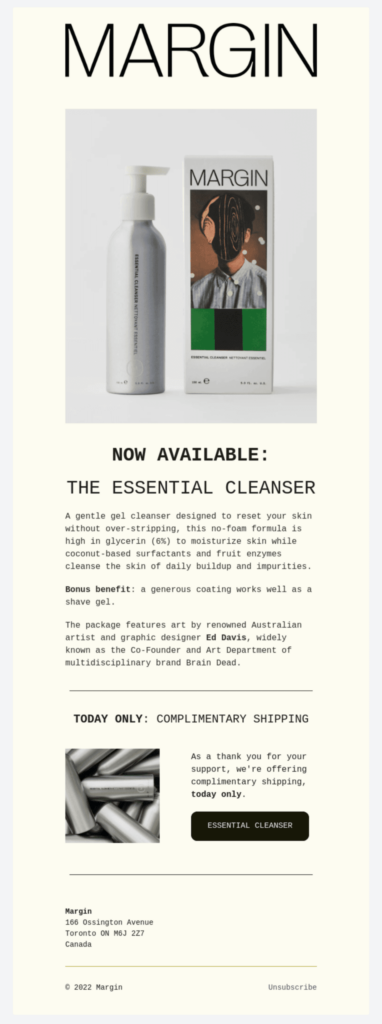
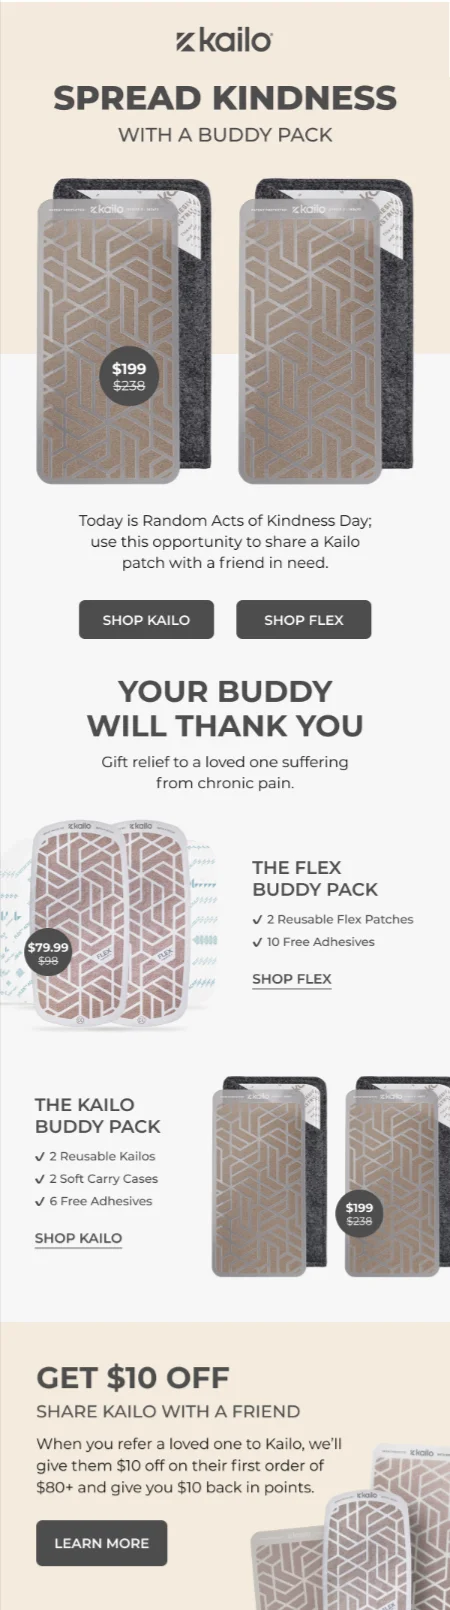

In [155]:
query =  """ 
Back in stock
"""
x = create_text_embeddings(query).tolist()

results = index.query(
    namespace="ns1",
    vector=x,
    top_k=5,
    include_values=False,
    include_metadata=True
)
 


display.display(display.HTML(
    show_emails_html_from_query(results, images_df)
))